In [8]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from scipy.stats import shapiro, levene
import seaborn as sns
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Malgun Gothic'  # 윈도우: 맑은 고딕
plt.rcParams['axes.unicode_minus'] = False 

In [5]:
# 결과 파일 폴더
result_dir = "C:/Users/User/Vscode/EDA25-1/data/keyword_exp_results"  # 폴더 경로를 환경에 맞게 지정

# 모든 csv 파일 리스트
csv_files = glob.glob(os.path.join(result_dir, "*.csv"))

# 결과 저장용 리스트
summary_list = []

for file in csv_files:
    # 파일명에서 모델명과 threshold 추출
    basename = os.path.basename(file)
    # 예: result_BM-K_KoSimCSE-roberta-multitask_th0.30_n2.csv
    parts = basename.split('_')
    model = '_'.join(parts[1:-2])
    threshold = float(parts[-2].replace('th',''))
    n = int(parts[-1].replace('.csv','').replace('n',''))

    # 파일 불러오기
    df = pd.read_csv(file)
    # 키워드 카운팅
    all_keywords = []
    for kws in df['top_keywords']:
        all_keywords.extend([kw.strip() for kw in kws.split(',') if kw.strip()])
    keyword_counts = Counter(all_keywords)
    # 각 키워드와 빈도 결과를 저장
    for kw, count in keyword_counts.items():
        summary_list.append({
            'model': model,
            'threshold': threshold,
            'n': n,
            'keyword': kw,
            'count': count
        })

# 전체 결과를 DataFrame으로 통합
summary_df = pd.DataFrame(summary_list)

# 분석 예시: 모델별, threshold별, 키워드별 등장 빈도 pivot
pivot = summary_df.pivot_table(index=['model', 'threshold', 'keyword'], values='count', aggfunc='sum').reset_index()

# 원하는 대로 분석/시각화
print(pivot.head())

# 예시: 모델별/threshold별, 상위 5개 키워드 빈도 출력
for (model, threshold), group in pivot.groupby(['model','threshold']):
    print(f"\n[{model} | threshold={threshold}]")
    print(group.sort_values('count', ascending=False)[['keyword','count']].head())

# 필요시 파일로 저장
#pivot.to_csv("all_models_keywords_summary.csv", index=False, encoding='utf-8-sig')

                          model  threshold keyword  count
0  BM-K_KoSimCSE-bert-multitask        0.3      가족     16
1  BM-K_KoSimCSE-bert-multitask        0.3      도시      1
2  BM-K_KoSimCSE-bert-multitask        0.3      문화      6
3  BM-K_KoSimCSE-bert-multitask        0.3      사진      1
4  BM-K_KoSimCSE-bert-multitask        0.3      산책     27

[BM-K_KoSimCSE-bert-multitask | threshold=0.3]
   keyword  count
4       산책     27
12      체험     20
0       가족     16
6       야경     15
9       자연     14

[BM-K_KoSimCSE-bert-multitask | threshold=0.35]
   keyword  count
18      산책     22
25      체험     16
20      야경     14
16      가족     12
22      자연      7

[BM-K_KoSimCSE-bert-multitask | threshold=0.4]
   keyword  count
31      산책     22
38      체험     14
33      야경     13
29      가족     12
30      문화      5

[BM-K_KoSimCSE-bert-multitask | threshold=0.45]
   keyword  count
44      산책     21
46      야경     13
51      체험     13
42      가족     12
43      문화      5

[BM-K_KoSimCSE-bert-multi

In [23]:
agg = summary_df.groupby(['model', 'threshold'])['count'].sum().reset_index(name='total_count')
print(agg.head(20))

                                  model  threshold  total_count
0          BM-K_KoSimCSE-bert-multitask       0.30          121
1          BM-K_KoSimCSE-bert-multitask       0.35           95
2          BM-K_KoSimCSE-bert-multitask       0.40           88
3          BM-K_KoSimCSE-bert-multitask       0.45           86
4          BM-K_KoSimCSE-bert-multitask       0.50           85
5       BM-K_KoSimCSE-roberta-multitask       0.30          157
6       BM-K_KoSimCSE-roberta-multitask       0.35          119
7       BM-K_KoSimCSE-roberta-multitask       0.40           93
8       BM-K_KoSimCSE-roberta-multitask       0.45           86
9       BM-K_KoSimCSE-roberta-multitask       0.50           86
10  snunlp_KR-SBERT-V40K-klueNLI-augSTS       0.30          108
11  snunlp_KR-SBERT-V40K-klueNLI-augSTS       0.35           90
12  snunlp_KR-SBERT-V40K-klueNLI-augSTS       0.40           85
13  snunlp_KR-SBERT-V40K-klueNLI-augSTS       0.45           85
14  snunlp_KR-SBERT-V40K-klueNLI-augSTS 

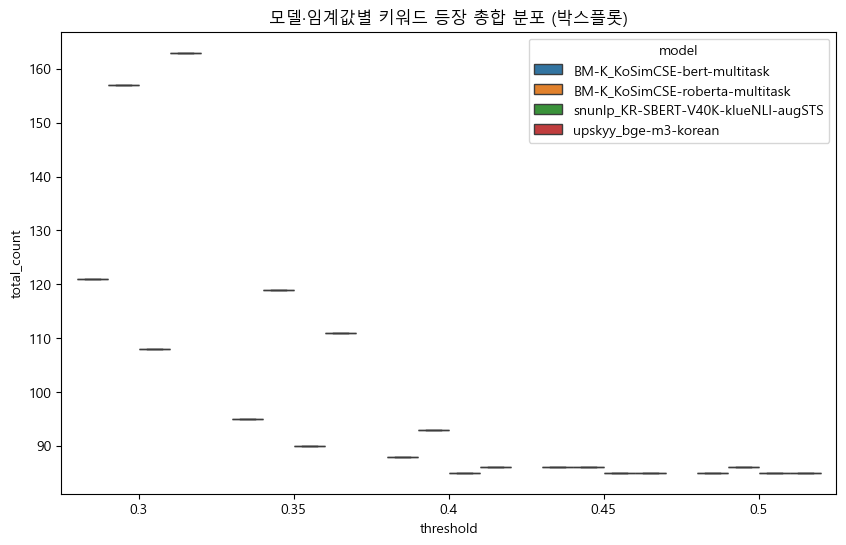

In [24]:
plt.figure(figsize=(10,6))
sns.boxplot(x='threshold', y='total_count', hue='model', data=agg)
plt.title('모델·임계값별 키워드 등장 총합 분포 (박스플롯)')
plt.show()

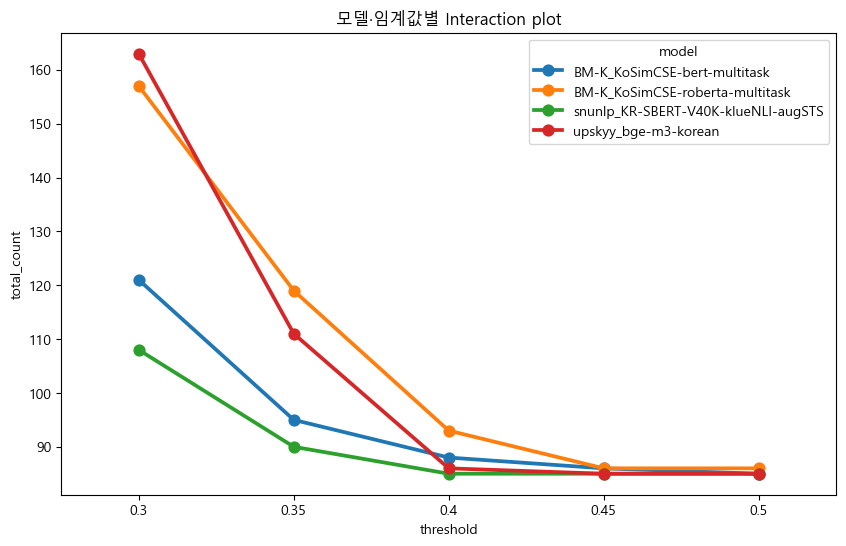

In [25]:
plt.figure(figsize=(10,6))
sns.pointplot(x='threshold', y='total_count', hue='model', data=agg, markers='o')
plt.title('모델·임계값별 Interaction plot')
plt.show()

In [26]:
# 4. 정규성/등분산 검정
print('\n--- 정규성/등분산성 검정 ---')
# 정규성: threshold별로 (모델별로도 가능)
for th in agg['threshold'].unique():
    data = agg[agg['threshold']==th]['total_count']
    stat, p = shapiro(data)
    print(f'threshold={th}: Shapiro-Wilk p={p:.4f}')

# 등분산성: Levene's test (모델별 그룹)
groups = [g['total_count'].values for _,g in agg.groupby('model')]
stat, p = levene(*groups)
print(f'Levene 등분산성 p={p:.4f}')




--- 정규성/등분산성 검정 ---
threshold=0.3: Shapiro-Wilk p=0.3492
threshold=0.35: Shapiro-Wilk p=0.5754
threshold=0.4: Shapiro-Wilk p=0.4051
threshold=0.45: Shapiro-Wilk p=0.0239
threshold=0.5: Shapiro-Wilk p=0.0012
Levene 등분산성 p=0.6192


In [20]:
print(agg.isnull().sum())
print(np.isinf(agg['total_count']).sum())
print(agg.head(10))

model          0
threshold      0
total_count    0
dtype: int64
0
                             model  threshold  total_count
0     BM-K_KoSimCSE-bert-multitask       0.30          121
1     BM-K_KoSimCSE-bert-multitask       0.35           95
2     BM-K_KoSimCSE-bert-multitask       0.40           88
3     BM-K_KoSimCSE-bert-multitask       0.45           86
4     BM-K_KoSimCSE-bert-multitask       0.50           85
5  BM-K_KoSimCSE-roberta-multitask       0.30          157
6  BM-K_KoSimCSE-roberta-multitask       0.35          119
7  BM-K_KoSimCSE-roberta-multitask       0.40           93
8  BM-K_KoSimCSE-roberta-multitask       0.45           86
9  BM-K_KoSimCSE-roberta-multitask       0.50           86


In [21]:
max_row = agg.loc[agg['total_count'].idxmax()]
print('\n--- 최적 조합 ---')
print(f"최고 total_count: {max_row['total_count']} | 모델: {max_row['model']} | threshold: {max_row['threshold']}")


--- 최적 조합 ---
최고 total_count: 163 | 모델: upskyy_bge-m3-korean | threshold: 0.3
